In [2]:
#### PACKAGE IMPORTS ####


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB2,EfficientNetB3,EfficientNetB5,InceptionResNetV2#,EfficientNetV2S
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
import keras
import sklearn.metrics as metrics
from sklearn.metrics import classification_report
#from pretty_confusion_matrix import pp_matrix
#confusion_matrix = metrics.confusion_matrix(y_true=y_test_labels, y_pred=pred_labels)  # shape=(12, 12)
from sklearn.metrics import confusion_matrix

import tensorflow as tf
import tensorflow_probability as tfp
import os
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.losses import SparseCategoricalCrossentropy,CategoricalCrossentropy
from tensorflow.keras.optimizers import RMSprop

tfd = tfp.distributions
tfpl = tfp.layers

# If you would like to make further imports from tensorflow, add them here


In [3]:
def load_dataset(image_type):
    file_dir=''
    x_train = []
    y_train = []
    x_test = []
    y_test = []
    
    x_holdout=[]
    y_holdout = []
    
    new_size = 224
    labels=[]
    
    #Declarations
    train_test_file_path =''
    holdout_file_path = './content'

    
    #get the labels 
    for sub_folder in os.listdir(os.path.join(file_dir,'Training')):
        labels.append(sub_folder)

    
    for i in labels:
        holdout_counter =0
        training_counter =0
        train_path = os.path.join(file_dir,'Training',i)
        test_path = os.path.join(file_dir,'Testing',i)
        holdout_path =os.path.join(holdout_file_path,'NoiseTestData',i)
        
        for j in tqdm(os.listdir(train_path)):
            training_counter += 1
            if training_counter ==500:
                break
            img = cv2.imread(os.path.join(train_path,j))
            img = cv2.resize(img,(new_size, new_size))
            x_train.append(img)
            y_train.append(i)
            
        
        for j in tqdm(os.listdir(test_path)):
            img = cv2.imread(os.path.join(test_path,j))
            img = cv2.resize(img,(new_size, new_size))
            x_test.append(img)
            y_test.append(i)         
 
        
        for j in tqdm(os.listdir(holdout_path)):
            holdout_counter += 1
            if holdout_counter ==30:
                break
            img = cv2.imread(os.path.join(holdout_path,j))
            img = cv2.resize(img,(new_size, new_size))
            x_holdout.append(img)
            y_holdout.append(i)       
    
    
    #Some preprocessing 
    x_train, y_train = shuffle(x_train,y_train, random_state=42)
    x_test, y_test = shuffle(x_test, y_test, random_state = 42)

    # convert the labels too one-hot encoder
    labelEncoder = LabelEncoder()
    labels_train=labelEncoder.fit(y_train)
    y_train=labelEncoder.transform(y_train)
    y_test = labelEncoder.transform(y_test)
    y_holdout = labelEncoder.transform(y_holdout)

    #make one hot 
    y_train_oh = tf.keras.utils.to_categorical(y_train)
    y_test_oh=tf.keras.utils.to_categorical(y_test)
    y_holhout_oh = tf.keras.utils.to_categorical(y_holdout)

    #x_train,x_test,y_train_oh,y_test_oh,y_train,y_test = train_test_split(x_train,y_train_oh,y_train, test_size=0.2,random_state=42,stratify=None)

    x_train = np.array(x_train)/255.
    y_train = np.array(y_train)
    x_test = np.array(x_test)/255.
    y_test = np.array(y_test)
    
    x_holdout = np.array(x_holdout)/255.
    y_holdout = np.array(y_holdout)
    
    print(f'The size of x_test is {x_test.shape} ')
    return (x_train, y_train, y_train_oh), (x_test, y_test, y_test_oh),(x_holdout,y_holdout,y_holhout_oh)

In [4]:
# Function to inspect dataset digits

def inspect_images(data, num_images):
    print(data.shape)
    fig, ax = plt.subplots(nrows=1, ncols=num_images, figsize=(2*num_images, 2))
    for i in range(num_images):
        ax[i].imshow(data[i, ..., 0], cmap='gray')
        ax[i].axis('off')
    plt.show()

In [5]:
# Load and inspect the MNIST dataset

(x_train, y_train, y_train_oh), (x_test, y_test, y_test_oh),(x_holdout,y_holdout,y_holdout_oh)= load_dataset('BRAIN_MRI')



  8%|▊         | 29/361 [00:00<00:00, 796.84it/s]


The size of x_test is (1311, 224, 224, 3) 


(1996, 224, 224, 3)


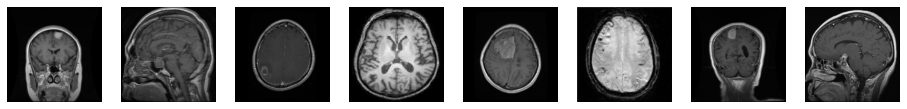

In [6]:
inspect_images(data=x_train, num_images=8)

(116, 224, 224, 3)


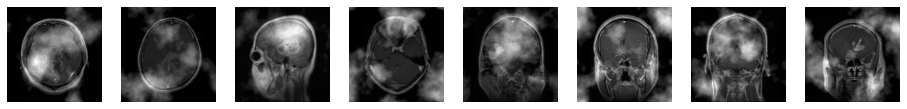

In [7]:
## inspect holdout with red noise
inspect_images(data=x_holdout, num_images=8)

In [8]:
def get_deterministic_model(input_shape, loss, optimizer, metrics):
    """
    This function should build and compile a CNN model according to the above specification. 
    The function takes input_shape, loss, optimizer and metrics as arguments, which should be
    used to define and compile the model.
    Your function should return the compiled model.
    """
    model = Sequential([
        Conv2D(input_shape=input_shape,filters=8, kernel_size=(5,5),activation='relu',padding='VALID'),
        MaxPooling2D((6,6)),
        Flatten(),
        Dense(units=4,activation='softmax')
    ])
    
    model.compile(loss=loss,optimizer=optimizer,metrics=metrics)
    
    return model

In [1]:
def get_deterministic_cnn_model(input_shape, loss, optimizer, metrics):
    """
    This function should build and compile a CNN model according to the above specification. 
    The function takes input_shape, loss, optimizer and metrics as arguments, which should be
    used to define and compile the model.
    Your function should return the compiled model.
    """
    model = tf.keras.models.Sequential([
        # YOUR CODE HERE, BUT END WITH A 3 Neuron Dense, activated by softmax
            # Note the input shape is the desired size of the image 150x150 with 3 bytes color
            # This is the first convolution
            tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(224, 224, 3)),
            tf.keras.layers.MaxPooling2D(2, 2),
            # The second convolution
            tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
            tf.keras.layers.MaxPooling2D(2, 2),
            # The third convolution
            tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
            tf.keras.layers.MaxPooling2D(2, 2),
            # The fourth convolution
            tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
            tf.keras.layers.MaxPooling2D(2, 2),
            # Flatten the results to feed into a DNN
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(4, activation='softmax')
        ])
    
    model.compile(loss=loss,optimizer=optimizer,metrics=metrics)
    
    return model

In [10]:
tf.random.set_seed(0)
deterministic_model = get_deterministic_model(
    input_shape=(224, 224, 3), 
    loss=SparseCategoricalCrossentropy(), 
    optimizer=RMSprop(), 
    metrics=['accuracy']
)

In [11]:
# Print the model summary

deterministic_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 220, 220, 8)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 36, 36, 8)        0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 10368)             0         
                                                                 
 dense (Dense)               (None, 4)                 41476     
                                                                 
Total params: 42,084
Trainable params: 42,084
Non-trainable params: 0
_________________________________________________________________


In [12]:
# Train the model

deterministic_model.fit(x_train, y_train, epochs=25)

2022-08-14 06:34:16.953998: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1201815552 exceeds 10% of free system memory.
2022-08-14 06:34:18.172904: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1201815552 exceeds 10% of free system memory.


Epoch 1/25
63/63 [==============================] - 4s 16ms/step - loss: 0.9600 - accuracy: 0.6177
Epoch 2/25
63/63 [==============================] - 1s 15ms/step - loss: 0.6391 - accuracy: 0.7680
Epoch 3/25
63/63 [==============================] - 1s 14ms/step - loss: 0.5074 - accuracy: 0.8136
Epoch 4/25
63/63 [==============================] - 1s 15ms/step - loss: 0.4056 - accuracy: 0.8622
Epoch 5/25
63/63 [==============================] - 1s 15ms/step - loss: 0.3282 - accuracy: 0.8798
Epoch 6/25
63/63 [==============================] - 1s 15ms/step - loss: 0.2586 - accuracy: 0.9128
Epoch 7/25
63/63 [==============================] - 1s 15ms/step - loss: 0.2049 - accuracy: 0.9354
Epoch 8/25
63/63 [==============================] - 1s 14ms/step - loss: 0.1646 - accuracy: 0.9464
Epoch 9/25
63/63 [==============================] - 1s 15ms/step - loss: 0.1246 - accuracy: 0.9624
Epoch 10/25
63/63 [==============================] - 1s 15ms/step - loss: 0.1029 - accuracy: 0.9709
Epoch 11/

In [13]:
# Evaluate the model

print('Accuracy on Brain MRI test set: ',
      str(deterministic_model.evaluate(x_test, y_test, verbose=False)[1]))
print('Accuracy on Brain MRI with red noise set: ',
      str(deterministic_model.evaluate(x_holdout, y_holdout, verbose=False)[1]))

2022-08-14 06:34:45.670895: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 789368832 exceeds 10% of free system memory.
2022-08-14 06:34:46.451236: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 789368832 exceeds 10% of free system memory.


Accuracy on Brain MRI test set:  0.7345537543296814
Accuracy on Brain MRI with red noise set:  0.6724137663841248


## Probabilistic model - cnn

In [14]:
def nll(y_true, y_pred):
    """
    This function should return the negative log-likelihood of each sample
    in y_true given the predicted distribution y_pred. If y_true is of shape 
    [B, E] and y_pred has batch shape [B] and event_shape [E], the output 
    should be a Tensor of shape [B].
    """
    return -y_pred.log_prob(y_true)

In [15]:

def get_probabilistic_model(input_shape, loss, optimizer, metrics):
    """
    This function should return the probabilistic model according to the 
    above specification.
    The function takes input_shape, loss, optimizer and metrics as arguments, which should be
    used to define and compile the model.
    Your function should return the compiled model.
    """
    event_shape=4
    model = Sequential([
        Conv2D(input_shape=input_shape,filters=8, kernel_size=(5,5),activation='relu',padding='VALID'),
        MaxPooling2D((6,6)),
        Flatten(),
        Dense(units=tfpl.OneHotCategorical.params_size(event_shape)),
        tfpl.OneHotCategorical(event_shape,
                               convert_to_tensor_fn=tfp.distributions.Distribution.mode)

    ])
    
    model.compile(loss=loss,optimizer=optimizer,metrics=metrics)
    
    return model
    

In [16]:
# Run your function to get the probabilistic model

tf.random.set_seed(0)
probabilistic_model = get_probabilistic_model(
    input_shape=(224, 224, 3), 
    loss=nll, 
    optimizer=RMSprop(), 
    metrics=['accuracy']
)

2022-08-14 06:34:47.902372: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


In [17]:

probabilistic_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 220, 220, 8)       608       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 8)        0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 10368)             0         
                                                                 
 dense_1 (Dense)             (None, 4)                 41476     
                                                                 
 one_hot_categorical (OneHot  ((None, 4),              0         
 Categorical)                 (None, 4))                         
                                                                 
Total params: 42,084
Trainable params: 42,084
Non-trai

In [18]:
# Train the model

probabilistic_model.fit(x_train, y_train_oh, epochs=25)

2022-08-14 06:34:49.084163: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1201815552 exceeds 10% of free system memory.


Epoch 1/25
63/63 [==============================] - 1s 15ms/step - loss: 0.9600 - accuracy: 0.6187
Epoch 2/25
63/63 [==============================] - 1s 15ms/step - loss: 0.6391 - accuracy: 0.7680
Epoch 3/25
63/63 [==============================] - 1s 15ms/step - loss: 0.5078 - accuracy: 0.8126
Epoch 4/25
63/63 [==============================] - 1s 15ms/step - loss: 0.4057 - accuracy: 0.8627
Epoch 5/25
63/63 [==============================] - 1s 15ms/step - loss: 0.3282 - accuracy: 0.8798
Epoch 6/25
63/63 [==============================] - 1s 15ms/step - loss: 0.2585 - accuracy: 0.9128
Epoch 7/25
63/63 [==============================] - 1s 15ms/step - loss: 0.2048 - accuracy: 0.9354
Epoch 8/25
63/63 [==============================] - 1s 15ms/step - loss: 0.1645 - accuracy: 0.9459
Epoch 9/25
63/63 [==============================] - 1s 15ms/step - loss: 0.1243 - accuracy: 0.9619
Epoch 10/25
63/63 [==============================] - 1s 15ms/step - loss: 0.1029 - accuracy: 0.9714
Epoch 11/

In [19]:

print('Accuracy on cleaned Brain MRI test set: ',
      str(probabilistic_model.evaluate(x_test, y_test_oh, verbose=False)[1]))
print('Accuracy on Brain MRI with red noise test set: ',
      str(probabilistic_model.evaluate(x_holdout, y_holdout_oh, verbose=False)[1]))

Accuracy on cleaned Brain MRI test set:  0.7704042792320251
Accuracy on Brain MRI with red noise test set:  0.767241358757019


In [20]:
# Check all the weights of the deterministic and probabilistic models are identical

for deterministic_variable, probabilistic_variable in zip(deterministic_model.weights, probabilistic_model.weights):
    print(np.allclose(deterministic_variable.numpy(), probabilistic_variable.numpy()))

False
False
False
False


In [21]:
def analyse_model_prediction(data, true_labels, model, image_num, run_ensemble=False):
    if run_ensemble:
        ensemble_size = 200
    else:
        ensemble_size = 1
    image = data[image_num]
    #true_label = true_labels[image_num, 0]
    true_label = true_labels[image_num]
  
    predicted_probabilities = np.empty(shape=(ensemble_size, 4))

    for i in range(ensemble_size):
        predicted_probabilities[i] = model(image[np.newaxis, :]).mean().numpy()[0]
    model_prediction = model(image[np.newaxis, :])
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 2),
                                   gridspec_kw={'width_ratios': [2, 4]})

    # Show the image and the true label
    ax1.imshow(image[..., 0], cmap='gray')
    ax1.axis('off')
    ax1.set_title('True label: {}'.format(str(true_label)))
    
    # Show a 95% prediction interval of model predicted probabilities
    pct_2p5 = np.array([np.percentile(predicted_probabilities[:, i], 2.5) for i in range(4)])
    pct_97p5 = np.array([np.percentile(predicted_probabilities[:, i], 97.5) for i in range(4)])    
    bar = ax2.bar(np.arange(4), pct_97p5, color='red')
    bar[int(true_label)].set_color('green')
    ax2.bar(np.arange(4), pct_2p5-0.02, color='white', linewidth=1, edgecolor='white')
    ax2.set_xticks(np.arange(4))
    ax2.set_ylim([0, 1])
    ax2.set_ylabel('Probability')
    ax2.set_title('Model estimated probabilities')
    plt.show()

In [22]:
##MRI with red noise

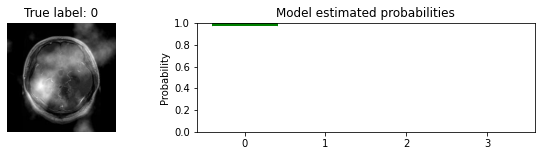

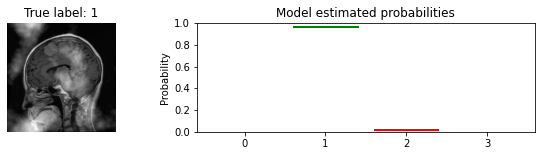

In [23]:
for i in [0, 33]:
    analyse_model_prediction(x_holdout, y_holdout, probabilistic_model, i)

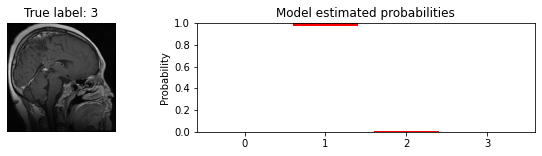

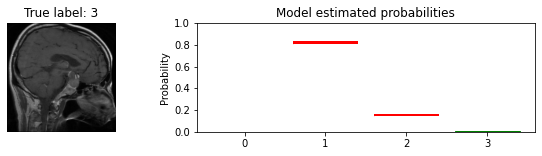

In [24]:
for i in [0, 25]:
    analyse_model_prediction(x_test, y_test, probabilistic_model, i)

In [25]:
def get_correct_indices(model, x, labels):
    y_model = model(x)
    correct = np.argmax(y_model.mean(), axis=1) == np.squeeze(labels)
    correct_indices = [i for i in range(x.shape[0]) if correct[i]]
    incorrect_indices = [i for i in range(x.shape[0]) if not correct[i]]
    return correct_indices, incorrect_indices


def plot_entropy_distribution(model, x, labels):
    probs = model(x).mean().numpy()
    entropy = -np.sum(probs * np.log2(probs), axis=1)
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    for i, category in zip(range(2), ['Correct', 'Incorrect']):
        entropy_category = entropy[get_correct_indices(model, x, labels)[i]]
        mean_entropy = np.mean(entropy_category)
        num_samples = entropy_category.shape[0]
        title = category + 'ly labelled ({:.1f}% of total)'.format(num_samples / x.shape[0] * 100)
        axes[i].hist(entropy_category, weights=(1/num_samples)*np.ones(num_samples))
        axes[i].annotate('Mean: {:.3f} bits'.format(mean_entropy), (0.4, 0.9), ha='center')
        axes[i].set_xlabel('Entropy (bits)')
        axes[i].set_ylim([0, 1])
        axes[i].set_ylabel('Probability')
        axes[i].set_title(title)
    plt.show()

MNIST test set:


/tmp/ipykernel_78/3935888667.py:11: RuntimeWarning: divide by zero encountered in log2
  entropy = -np.sum(probs * np.log2(probs), axis=1)
/tmp/ipykernel_78/3935888667.py:11: RuntimeWarning: invalid value encountered in multiply
  entropy = -np.sum(probs * np.log2(probs), axis=1)


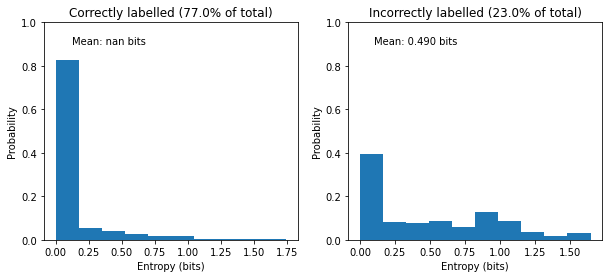

In [26]:
# Entropy plots for the MNIST dataset

print('MNIST test set:')
plot_entropy_distribution(probabilistic_model, x_test, y_test)

MNIST test set:


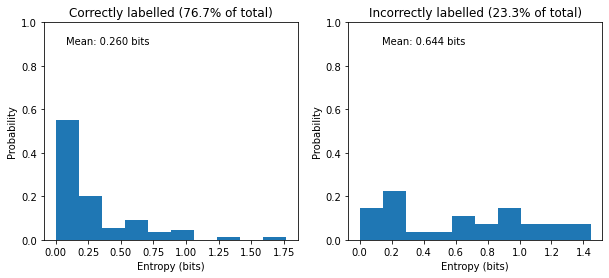

In [27]:

print('MNIST test set:')
plot_entropy_distribution(probabilistic_model, x_holdout, y_holdout)

## Bayesian CNN 

In [28]:
def build_convolutional_reparameterization_layer(input_shape,divergence_func):
    
    con_reparameterization_layer = tfpl.Convolution2DReparameterization(
        input_shape=input_shape,
        filters=8,kernel_size=(5,5),
        activation='relu',padding='VALID',
        kernel_prior_fn=tfpl.default_multivariate_normal_fn,
        kernel_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
        kernel_divergence_fn=divergence_func,
        bias_prior_fn=tfpl.default_multivariate_normal_fn,
        bias_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
        bias_divergence_fn=divergence_func)
    
    return con_reparameterization_layer




## Custom Prior - to allow 
Allowing model to explore a larger weight space.

This distribution has a density that is the weighted sum of two normally distributed ones: one with a standard deviation of 1 and one with a standard deviation of 10. In this way, it has a sharp spike around 0 (from the normal distribution with standard deviation 1), but is also more spread out towards far away values (from the contribution from the normal distribution with standard deviation 10). The reason for using such a prior is that it is like a standard unit normal, but makes values far away from 0 more likely, allowing the model to explore a larger weight space. 

In [29]:

def spike_and_slab(event_shape, dtype):
    distribution = tfd.Mixture(
        cat=tfd.Categorical(probs=[0.5, 0.5]),
        components=[
            tfd.Independent(tfd.Normal(
                loc=tf.zeros(event_shape, dtype=dtype), 
                scale=1.0*tf.ones(event_shape, dtype=dtype)),
                            reinterpreted_batch_ndims=1),
            tfd.Independent(tfd.Normal(
                loc=tf.zeros(event_shape, dtype=dtype), 
                scale=10.0*tf.ones(event_shape, dtype=dtype)),
                            reinterpreted_batch_ndims=1)],
    name='spike_and_slab')
    return distribution

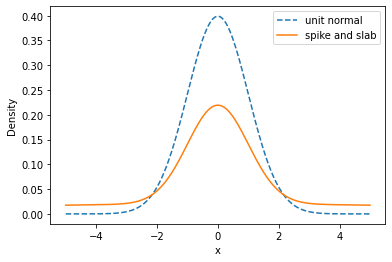

In [30]:
# Plot the spike and slab distribution pdf

x_plot = np.linspace(-5, 5, 1000)[:, np.newaxis]
plt.plot(x_plot, tfd.Normal(loc=0, scale=1).prob(x_plot).numpy(), label='unit normal', linestyle='--')
plt.plot(x_plot, spike_and_slab(1, dtype=tf.float32).prob(x_plot).numpy(), label='spike and slab')
plt.xlabel('x')
plt.ylabel('Density')
plt.legend()
plt.show()

In [31]:
## Creating Prior for DenseVariational

def get_variational_prior(kernel_size, bias_size, dtype=None):

    n = kernel_size+bias_size  
    prior_model = Sequential([tfpl.DistributionLambda(lambda t : spike_and_slab(n, dtype))])
    return prior_model

In [32]:

def get_variational_posterior(kernel_size, bias_size, dtype=None):

    n = kernel_size + bias_size
    return Sequential([
        tfpl.VariableLayer(tfpl.IndependentNormal.params_size(n), dtype=dtype),
        tfpl.IndependentNormal(n)
    ])
    
    
    

In [33]:
def build_dense_variational_layer(prior_fn, posterior_fn, kl_weight):

    return tfpl.DenseVariational(
        units=4, make_posterior_fn=posterior_fn, make_prior_fn=prior_fn, kl_weight=kl_weight
    )

In [34]:
#Create layers 
tf.random.set_seed(0)
divergence_func = lambda q, p, _ : tfd.kl_divergence(q, p) / x_train.shape[0]


convolutional_reparameterization_layer = build_convolutional_reparameterization_layer(
    input_shape=(224, 224, 3), divergence_func=divergence_func
)
dense_variational_layer = build_dense_variational_layer(
    get_variational_prior, get_variational_posterior, kl_weight=1/x_train.shape[0]
)

In [35]:
## Build Bayesian CNN

In [36]:
# Build and compile the Bayesian CNN model

bayesian_model = Sequential([
    convolutional_reparameterization_layer,
    MaxPooling2D(pool_size=(6, 6)),
    Flatten(),
    dense_variational_layer,
    tfpl.OneHotCategorical(4, convert_to_tensor_fn=tfd.Distribution.mode)
    
])



/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/tensorflow_probability/python/layers/util.py:95: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  loc = add_variable_fn(
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/tensorflow_probability/python/layers/util.py:105: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  untransformed_scale = add_variable_fn(


In [37]:
bayesian_model.compile(loss=nll,
              optimizer=RMSprop(),
              metrics=['accuracy'],
              experimental_run_tf_function=False)

In [38]:
# Print the model summary

bayesian_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_reparameterization (  (None, 220, 220, 8)      1216      
 Conv2DReparameterization)                                       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 36, 36, 8)        0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 10368)             0         
                                                                 
 dense_variational (DenseVar  (None, 4)                82952     
 iational)                                                       
                                                                 
 one_hot_categorical_1 (OneH  ((None, 4),              0         
 otCategorical)               (None, 4))              

In [45]:
bayesian_model.fit(x=x_train, y=y_train_oh, epochs=50, verbose=True)

Epoch 1/50
63/63 [==============================] - 1s 15ms/step - loss: 1.4517 - accuracy: 0.7771
Epoch 2/50
63/63 [==============================] - 1s 15ms/step - loss: 1.3791 - accuracy: 0.7911
Epoch 3/50
63/63 [==============================] - 1s 15ms/step - loss: 1.4011 - accuracy: 0.8026
Epoch 4/50
63/63 [==============================] - 1s 15ms/step - loss: 1.3312 - accuracy: 0.7966
Epoch 5/50
63/63 [==============================] - 1s 15ms/step - loss: 1.3131 - accuracy: 0.8156
Epoch 6/50
63/63 [==============================] - 1s 15ms/step - loss: 1.3242 - accuracy: 0.7911
Epoch 7/50
63/63 [==============================] - 1s 15ms/step - loss: 1.3102 - accuracy: 0.8011
Epoch 8/50
63/63 [==============================] - 1s 15ms/step - loss: 1.2690 - accuracy: 0.8196
Epoch 9/50
63/63 [==============================] - 1s 15ms/step - loss: 1.2644 - accuracy: 0.8031
Epoch 10/50
63/63 [==============================] - 1s 15ms/step - loss: 1.2691 - accuracy: 0.8136
Epoch 11/

In [46]:
# Evaluate the model

print('Accuracy on MNIST test set: ',
      str(bayesian_model.evaluate(x_test, y_test_oh, verbose=False)[1]))
print('Accuracy on corrupted MNIST test set: ',
      str(bayesian_model.evaluate(x_holdout, y_holdout_oh, verbose=False)[1]))

Accuracy on MNIST test set:  0.5530129671096802
Accuracy on corrupted MNIST test set:  0.4655172526836395


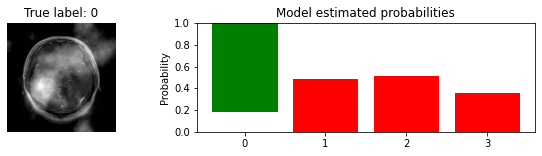

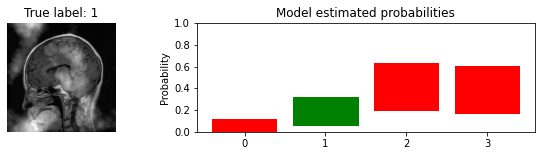

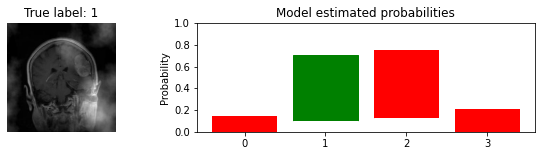

In [47]:
for i in [0, 33,55]:
    analyse_model_prediction(x_holdout, y_holdout, bayesian_model, i,run_ensemble=True)

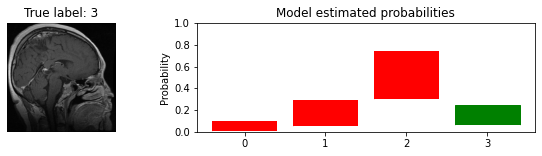

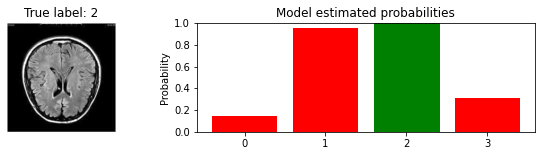

In [48]:
 for i in [0, 33]:
    analyse_model_prediction(x_test, y_test, bayesian_model, i,run_ensemble=True)

#### Uncertainty quantification using entropy

We also again plot the distribution of distribution entropy across the different test sets below. In these plots, no consideration has been made for the epistemic uncertainty, and the conclusions are broadly similar to those for the previous model.

MRI test set:


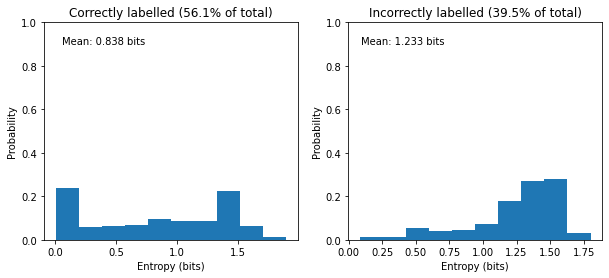

In [49]:
print('MRI test set:')
plot_entropy_distribution(bayesian_model, x_test, y_test)

MRI with red noise :


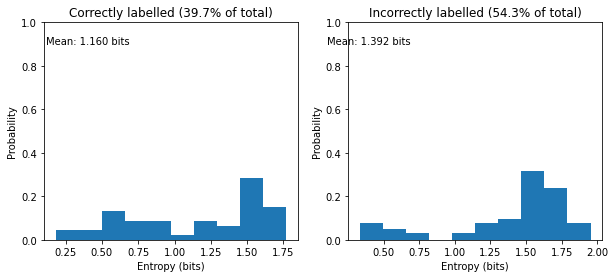

In [50]:
print('MRI with red noise :')
plot_entropy_distribution(bayesian_model, x_holdout, y_holdout)

In [ ]:
bayesian_model